<a href="https://colab.research.google.com/github/sakhnos/Wabs-Wsc/blob/master/Wabs(t).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part


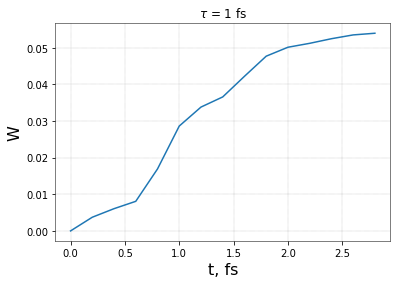

In [35]:
%reset -f 
import numpy as np
import math
from scipy.integrate import odeint
#from numpy import linspace, array
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter  


def EGauss(t, w0, tau, E0, phi):
  return E0 * np.exp(-t ** 2 / (2 * tau ** 2)) * np.cos(w0*t + phi)


def IntSquared(t, w0, tau, E0, phi):
  tt = np.arange(-t, t, 0.03) 
  J = np.zeros(len(tt))
  for i in range(len(J)):
    J[i] = np.exp(1j * w0 * tt[i]) * EGauss(tt[i], w0, tau, E0, phi)
  integral = np.trapz(J, tt)
  return np.abs(integral) ** 2
  
#print(IntSquared(1, 1, 0.1, 1, 0))
aB = 0.052 # Bohr's radius in nm
wmax = 5
c = 137
wp = 2.48 / 27.2 # eV resonant freq of plasmon
G = 0.248 / 27.2 # gamma, q = 10
R = 0.4 / aB # nm


def alpha(w, wp, R, G):   # dynamic polarizability
  a = R ** 3 * wp ** 2 / (wp ** 2 - w ** 2 - 1j * w * G)
  return a

def sigma_abs(w, wp, R, G):
  cross_abs = 4 * np.pi * w * np.imag(alpha(w, wp, R, G)) / c   # Optical theorem, p. 184 VA
  return  cross_abs 

def W(t, tau, E0, phi):
  ww = np.arange(0.000001, wmax, 0.03) / 27.2
  J = np.zeros(len(ww))
  for i in range (len(ww)):
    J[i] = sigma_abs(ww[i], wp, R, G) * IntSquared(t / 0.024, ww[i], tau / 0.024, E0, phi) / ww[i] 
  integral =  (c / (4 * np.pi ** 2) ) * np.trapz(J, ww)   
  return integral 

def W_visualisation():            
  t = np.arange(0., 3, 0.2)    # in fs         
  Wabs = np.zeros(len(t)) 
  tau = 1 # in fs
  E0 = 10 ** -3 # in at. u.
  phi = 0
               
  for i in range (len(t)):
       Wabs[i] = W(t[i], tau, E0, phi)
  
  fig = plt.figure()
  fig.patch.set_facecolor('xkcd:white') # outer color        
  plt.plot(t, Wabs)   
  ax = plt.gca()
  ax.set_facecolor((1.0, 1.0, 1.0))    # background color
  ax.spines['bottom'].set_linewidth(0.5)
  ax.spines['bottom'].set_color('0.0') 
  ax.spines['top'].set_linewidth(0.5)
  ax.spines['top'].set_color('0.0') 
  ax.spines['left'].set_linewidth(0.5)
  ax.spines['left'].set_color('0.0') 
  ax.spines['right'].set_linewidth(0.5)
  ax.spines['right'].set_color('0.0') 
  ax.grid(b=True, which='major', axis='both', color = 'k', linestyle=':', linewidth=0.2)
  plt.xlabel(r't, fs',  {'color': 'k', 'fontsize': 16})
  plt.ylabel(r'W', {'color': 'k', 'fontsize': 16})
  plt.title(r'$\tau$ = ' + str(tau) + " fs") 
  plt.show()
          
W_visualisation()                     